# NLP: Classify Articles from Titles

We will walk through an end-to-end example of taking the raw text of the articles' titles, clean it, tokenize and vectorize it, explore it, and develop a model to classify each article into one of 4 labeled classes (business, sports, technology, or entertainment). 

In [1]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import acquire

## Acquire: Scrape InShorts.com

Acquire news articles from [InShorts](inshorts.com) using `BeautifulSoup` and `get.requests`

- [business](https://inshorts.com/en/read/business)
- [sports](https://inshorts.com/en/read/sports)
- [technology](https://inshorts.com/en/read/technology)
- [entertainment](https://inshorts.com/en/read/entertainment)

In [2]:
original_df = acquire.get_news_articles()

In [3]:
original_df.head()

,Unnamed: 0,author,body,category,published_date,title
0,0,Krishna Veera Vanamali,"British cave explorer Vernon Unsworth, who los...",business,2019-12-07T15:31:16.000Z,I'll take it on the chin: Cave explorer after ...
1,1,Krishna Veera Vanamali,After a US jury found that Elon Musk did not d...,business,2019-12-07T16:34:59.000Z,My faith in humanity is restored: Musk after w...
2,2,Dharna,A Lucknow-based customer has filed an FIR agai...,business,2019-12-09T08:17:05.000Z,FIR filed against Club Factory in Lucknow for ...
3,3,Krishna Veera Vanamali,Finance Minister Nirmala Sitharaman on Saturda...,business,2019-12-07T12:36:59.000Z,Sitharaman hints at personal income tax rate c...
4,4,Pragya Swastik,Price of onion has shot up to ₹200 per kg in B...,business,2019-12-08T08:44:31.000Z,Onion prices surge up to ₹200 per kg in Bengaluru


We are only going to work with the article titles in this example. 
We will select title and category (our target variable) and assign those to a new dataframe that we will work with moving forward. 

In [4]:
df = original_df[['title','category']]

In [5]:
df.head()

,title,category
0,I'll take it on the chin: Cave explorer after ...,business
1,My faith in humanity is restored: Musk after w...,business
2,FIR filed against Club Factory in Lucknow for ...,business
3,Sitharaman hints at personal income tax rate c...,business
4,Onion prices surge up to ₹200 per kg in Bengaluru,business


In [6]:
df.shape

(99, 2)

## Prepare
### Normalize Text

- Convert to all lowercase  
- Normalize the unicode chars  
- Remove any non-alpha or whitespace characters  
- Remove any alpha strings with 2 characters or less  

In [7]:
string = df.title[0]
print(string)
string = string.lower()
print(string)
string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
print(string)

string = re.sub(r'[^a-z]', ' ', string)
print(string)

string = re.sub(r'\b[a-z]{,2}\b', '', string)
print(string)

string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
print(string)

string = re.sub(r'\s+', ' ', string)
print(string)

string = string.strip()
print(string)

I'll take it on the chin: Cave explorer after losing case against Elon Musk
i'll take it on the chin: cave explorer after losing case against elon musk
i'll take it on the chin: cave explorer after losing case against elon musk
i ll take it on the chin  cave explorer after losing case against elon musk
  take   the chin  cave explorer after losing case against elon musk
  take   the chin  cave explorer after losing case against elon musk
 take the chin cave explorer after losing case against elon musk
take the chin cave explorer after losing case against elon musk


In [8]:
def normalize(string):
    """
    Convert to all lowercase  
    Normalize the unicode chars  
    Remove any non-alpha or whitespace characters  
    Remove any alpha strings with 2 characters or less  
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # keep only alpha chars
    string = re.sub(r'[^a-z]', ' ', string)
    
    # remove strings less than 2 chars in length
    string = re.sub(r'\b[a-z]{,2}\b', '', string)
    
    # convert newlines and tabs to a single space
    string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
    
    # strip extra whitespace
    string = string.strip()
    
    return string

df = df.assign(normalized = df.title.apply(normalize))

### Stem

In [9]:
print(string)

ps = nltk.porter.PorterStemmer()
print(ps)
stems = [ps.stem(word) for word in string.split()]
print(stems)
stem_string = ' '.join(stems)
print(stem_string)

take the chin cave explorer after losing case against elon musk
<PorterStemmer>
['take', 'the', 'chin', 'cave', 'explor', 'after', 'lose', 'case', 'against', 'elon', 'musk']
take the chin cave explor after lose case against elon musk


In [10]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

### Lemmatize

In [11]:
print(string)
wnl = nltk.stem.WordNetLemmatizer()
lemmas = [wnl.lemmatize(word) for word in string.split()]
lemma_string = ' '.join(lemmas)
print(lemma_string)
print(stem_string)

take the chin cave explorer after losing case against elon musk
take the chin cave explorer after losing case against elon musk
take the chin cave explor after lose case against elon musk


In [12]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

### Tokenize

In [13]:
print(string)
tokenizer = nltk.tokenize.ToktokTokenizer()
tokenized_string = tokenizer.tokenize(string, return_str=True)

take the chin cave explorer after losing case against elon musk


In [14]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

### Remove Stopwords

In [15]:
words = tokenized_string.split()
print(words)
stopwords_list = stopwords.words('english')
exclude_words = ['me']
stopwords_list = set(stopwords_list) - set(exclude_words)
include_words = ['Dom']
stopwords_list = stopwords_list.union(set(include_words))
filtered_words = [w for w in words if w not in stopwords_list]
filtered_words = ' '.join(filtered_words)
filtered_words

['take', 'the', 'chin', 'cave', 'explorer', 'after', 'losing', 'case', 'against', 'elon', 'musk']


'take chin cave explorer losing case elon musk'

In [16]:
def remove_stopwords(tokenized_string, extra_words=[], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Prep Summary

In [17]:
df = original_df[['title','category']]
df.head()

,title,category
0,I'll take it on the chin: Cave explorer after ...,business
1,My faith in humanity is restored: Musk after w...,business
2,FIR filed against Club Factory in Lucknow for ...,business
3,Sitharaman hints at personal income tax rate c...,business
4,Onion prices surge up to ₹200 per kg in Bengaluru,business


In [18]:
df = original_df[['title','category']]
df = df.assign(original = df.title)

df = df.assign(normalized = df.original.apply(normalize))

df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))
# use lemmatize instead of stem
df = df.assign(cleaned = df.lemmatized.apply(remove_stopwords))
df.head()

,title,category,original,normalized,stemmed,lemmatized,cleaned
0,I'll take it on the chin: Cave explorer after ...,business,I'll take it on the chin: Cave explorer after ...,take the chin cave explorer after losing ca...,take the chin cave explor after lose case agai...,take the chin cave explorer after losing case ...,take chin cave explorer losing case elon musk
1,My faith in humanity is restored: Musk after w...,business,My faith in humanity is restored: Musk after w...,faith humanity restored musk after winning ...,faith human restor musk after win defam case,faith humanity restored musk after winning def...,faith humanity restored musk winning defamatio...
2,FIR filed against Club Factory in Lucknow for ...,business,FIR filed against Club Factory in Lucknow for ...,fir filed against club factory lucknow for se...,fir file against club factori lucknow for sell...,fir filed against club factory lucknow for sel...,fir filed club factory lucknow selling fake item
3,Sitharaman hints at personal income tax rate c...,business,Sitharaman hints at personal income tax rate c...,sitharaman hints personal income tax rate cut...,sitharaman hint person incom tax rate cut say ...,sitharaman hint personal income tax rate cut s...,sitharaman hint personal income tax rate cut s...
4,Onion prices surge up to ₹200 per kg in Bengaluru,business,Onion prices surge up to ₹200 per kg in Bengaluru,onion prices surge per bengaluru,onion price surg per bengaluru,onion price surge per bengaluru,onion price surge per bengaluru


In [19]:
def prep_articles(df):
    df = df.assign(original = df.title)
    df = df.assign(normalized = df.original.apply(normalize))
    df = df.assign(stemmed = df.normalized.apply(stem))
    df = df.assign(lemmatized = df.normalized.apply(lemmatize))
    df = df.assign(cleaned = df.lemmatized.apply(remove_stopwords))
    df.drop(columns=["title"], inplace=True)
    return df

### Wrangle Summary (Acquire + Prep)

1. acquire data via web scraping  
2. select the column of text to be used as features and the target variable  
3. prepare the text  
    - normalize the text  
    - lemmatize the normalized text  
    - remove stopwords from the lemmatized text  
    

In [20]:
def prep_news_articles(text, target):
    df = acquire.get_news_articles()
    df = df[[text, target]]
    df = prep_articles(df)
    return df

In [21]:
df = prep_news_articles('title','category')

In [22]:
df = df[['category','cleaned']]

df.head()

,category,cleaned
0,business,take chin cave explorer losing case elon musk
1,business,faith humanity restored musk winning defamatio...
2,business,fir filed club factory lucknow selling fake item
3,business,sitharaman hint personal income tax rate cut s...
4,business,onion price surge per bengaluru


## Explore & Define Features

We will do a very quick exploration, due to time, which will naturally blend into feature engineering.  

### Category Distribution

In [23]:
df.category.value_counts(normalize=True)

technology       0.252525
sports           0.252525
entertainment    0.252525
business         0.242424
Name: category, dtype: float64

In [24]:
pd.concat(
    [df.category.value_counts(), df.category.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)

,n,percent
technology,25,0.252525
sports,25,0.252525
entertainment,25,0.252525
business,24,0.242424


### Term Frequency

Generally, when you hear 'Term Frequency', it is referring to the number of documents in which a word appears.  
*When we move on to computing TF-IDF, this basic definition of Term Frequency applies*.  

However, term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.  

- **Raw Count**: This is simply the count of the number of occurances of each word.
- **Frequency**: The number of times each word appears divided by the total number of words.
- **Augmented Frequency**: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [25]:
# raw_count = pd.Series(' '.join(df[df.category=='business']['cleaned']).split()).value_counts()

In [26]:
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()

Text(0.5, 1.0, '10 most common words')

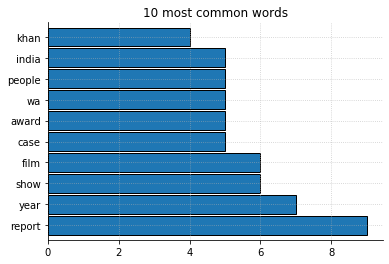

In [27]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words')

In [28]:
# type(raw_count)

tf_df = pd.DataFrame({'raw_count': raw_count})

tf_df = tf_df.assign(frequency = lambda df: df.raw_count / df.raw_count.sum())

tf_df = tf_df.assign(augmented_frequency = lambda df: df.frequency / df.frequency.max())

tf_df.frequency.max()

tf_df.head()

,raw_count,frequency,augmented_frequency
report,9,0.011734,1.000000
year,7,0.009126,0.777778
show,6,0.007823,0.666667
film,6,0.007823,0.666667
case,5,0.006519,0.555556


In [29]:
tf_df = (pd.DataFrame({'raw_count': raw_count})
         .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
         .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

tf_df.head(6)

,raw_count,frequency,augmented_frequency
report,9,0.011734,1.000000
year,7,0.009126,0.777778
show,6,0.007823,0.666667
film,6,0.007823,0.666667
case,5,0.006519,0.555556
award,5,0.006519,0.555556


### Inverse Document Frequency (IDF)

Inverse Document Frequency also provides information about individual words, but, in order to use this measure, we must have multiple documents, i.e. several different bodies of text.

- provides information about individual words in a document with respect the those words' frequency across the corpus, which must include multiple documents.  
- indicates how valuable a word is in terms of the information it provides.
- The more frequently a word appears in the corpus, the less information it provides when found in a certain document. This will lead to a lower IDF score. 
- Lower IDF $\rightarrow$ less important when found in a document, i.e. that word gives us less information about the document than a word with a high IDF. 
- Example: 'the' would have a *very* low IDF which indicates we learn very little about an individual document knowing that the word 'the' appears in it.  

$$
\mbox{idf}(\mbox{word})
=
\log\left(\frac{\mbox{# of documents}}{\mbox{# of documents containing the word + 1}}\right)
$$

Notes on IDF calculation

- If a given word doesn't appear in any documents, the denominator in the equation above would be zero, so it is best to add 1 to the denominator, as indicated above.   
- The denominator is *NOT* necessarily equivalent to Term Frequency, which is the total number of times the word appears in a corpus. When a word appears in a document more than once, these numbers will differ. 
    


For example, imagine we have 20 documents. We can visualize what the idf score looks like with the code below:

Text(0.5, 1.0, 'IDF for a given word')

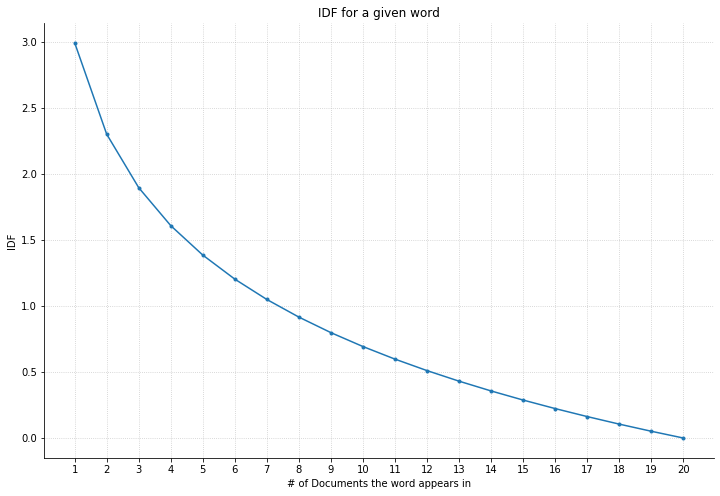

In [30]:
n_documents = 20

x_denominator = np.arange(1, n_documents + 1)
y_idf = np.log(n_documents / x_denominator)

plt.figure(figsize=(12, 8))
plt.plot(x_denominator, y_idf, marker='.')

plt.xticks(x_denominator)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

Compute IDF for the titles of the news ariticles. We need:  

- number of occurrences of the word (denominator)   
- total number of documents (numerator) 

First, let's compute IDF for a single word to see how it's done.  

In [31]:
print("word: india")
denom = sum([1 for doc in df.cleaned if 'india' in doc])
print("# of occurrences: ", denom)
num = len(df.cleaned)
print("# of documents: ", num)
idf = np.log(num/(denom+1))
print("idf = ", idf)

word: india
# of occurrences:  5
# of documents:  99
idf =  2.803360380906535


Write the IDF function

In [32]:
def idf(word):
    n_occurrences = sum([1 for doc in df.cleaned if word in doc])
    n_docs = len(df.cleaned)
    idf = np.log(n_docs/n_occurrences)
    return idf

Now, we need to do it for all words in our corpus. To do that, we need:  

- list of unique words  
- assign words to a dataframe  
- calculate the idf for each word  

#### Unique Words

- join all docs together into corpus as single document
- split corpus into single words & convert to list of words
- keep only a single, unique value for each word. (dedup)


In [33]:
part1 = ' '.join(df.cleaned)
part2 = part1.split()
part3 = pd.Series(part2)
# print(part3.value_counts())

part4 = part3.unique()
type(part4)
# confirm that those words that existed multiple times, are now only represented once in the unique_words list. 
# print(pd.Series(part4).value_counts())

numpy.ndarray

In [34]:
unique_words = pd.Series(' '.join(df.cleaned).split()).unique()

- add to a dataframe
- apply idf() to compute IDF for each unique word
- sort idf_df for quick peeks into the results

In [35]:
word_df = pd.DataFrame(dict(word = unique_words))
word_df.head()

word_df = word_df.assign(idf = lambda df: df.word.apply(idf))

word_df.set_index('word').sort_values(by='idf', ascending = False).head(5)

,idf
word,
learn,4.59512
warne,4.59512
gift,4.59512
ramdin,4.59512
oldest,4.59512


In [36]:
# put in a dataframe
idf_df = pd.DataFrame(dict(word = unique_words))\
    .assign(idf = lambda df: df.word.apply(idf))\
    .set_index('word').sort_values(by='idf', ascending = False)

idf_df.head(5)

,idf
word,
learn,4.59512
warne,4.59512
gift,4.59512
ramdin,4.59512
oldest,4.59512


### TF-IDF

In [37]:
documents = df.cleaned.to_dict()
# documents

text = df.cleaned[0]

pd.Series(text.split()).value_counts()\
    .reset_index()\
    .set_axis(['word','raw_count'], axis=1, inplace=False)\
    .assign(tf = lambda df: df.raw_count / df.shape[0])\
    .drop(columns=['raw_count'])\
    .assign(doc=0)

,word,tf,doc
0,case,0.125,0
1,losing,0.125,0
2,explorer,0.125,0
3,take,0.125,0
4,musk,0.125,0
5,chin,0.125,0
6,cave,0.125,0
7,elon,0.125,0


In [38]:
# We'll caclulate the tf-idf value for every word across every document
tfs = []

# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    tf_df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(tf_df)

In [39]:
tfs[0:2]

[       word     tf  doc
 0      case  0.125    0
 1    losing  0.125    0
 2  explorer  0.125    0
 3      take  0.125    0
 4      musk  0.125    0
 5      chin  0.125    0
 6      cave  0.125    0
 7      elon  0.125    0,          word        tf  doc
 0        case  0.142857    1
 1    restored  0.142857    1
 2     winning  0.142857    1
 3       faith  0.142857    1
 4    humanity  0.142857    1
 5        musk  0.142857    1
 6  defamation  0.142857    1]

In [40]:
tfidf_df = pd.concat(tfs)\
            .assign(idf = lambda tf_df: tf_df.word.apply(idf))\
            .assign(tf_idf = lambda tf_df: tf_df.idf * tf_df.tf)\
            .drop(columns=['tf', 'idf'])\
            .sort_values(by='tf_idf', ascending=False)

In [41]:
tfidf_df.head()

,word,doc,tf_idf
0,airport,6,1.312891
0,iphone,66,1.300658
0,walsh,36,1.148780
0,miss,80,1.114849
2,bengaluru,4,0.919024


### TF-IDF with Scikit-Learn

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())

This returns a sparse matrix:  
- a matrix with more 0s than anything else. 
- Numpy has a special type that makes some manipulations and operations faster on sparse matrices.

Becuase our data set is pretty small, we can convert our sparse matrix to a regular one, aka 'dense matrix', and put everything in a dataframe. If our data were larger, the operation below might take much longer.

In [43]:
features_df = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
features_df.head()

,aaryan,ab,able,account,across,actor,actress,adventurer,age,agrees,...,win,winning,without,worth,wrongly,year,yes,zero,zilingos,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.370672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [45]:
df.head()

,category,cleaned
0,business,take chin cave explorer losing case elon musk
1,business,faith humanity restored musk winning defamatio...
2,business,fir filed club factory lucknow selling fake item
3,business,sitharaman hint personal income tax rate cut s...
4,business,onion price surge per bengaluru


In [50]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.category

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [51]:
train.head()

,actual,predicted
61,technology,technology
49,technology,technology
55,technology,technology
69,technology,technology
26,sports,sports


In [52]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 96.20%
---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
business             18              0       0           0
entertainment         0             19       1           0
sports                0              1      19           0
technology            1              0       0          20
---
               precision    recall  f1-score   support

     business       1.00      0.95      0.97        19
entertainment       0.95      0.95      0.95        20
       sports       0.95      0.95      0.95        20
   technology       0.95      1.00      0.98        20

     accuracy                           0.96        79
    macro avg       0.96      0.96      0.96        79
 weighted avg       0.96      0.96      0.96        79



In [53]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 55.00%
---
Confusion Matrix
actual         business  entertainment  sports  technology
predicted                                                 
business              3              1       0           0
entertainment         0              3       2           0
sports                0              0       1           1
technology            2              1       2           4
---
               precision    recall  f1-score   support

     business       0.75      0.60      0.67         5
entertainment       0.60      0.60      0.60         5
       sports       0.50      0.20      0.29         5
   technology       0.44      0.80      0.57         5

     accuracy                           0.55        20
    macro avg       0.57      0.55      0.53        20
 weighted avg       0.57      0.55      0.53        20

